In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition, AdaptivePNormDistance,
                  PNormDistance, History, AdaptivePopulationSize)
try:
    from pyabc.visualization import kde_1d
except:
    from pyabc.visualization.kde import kde_1d  # location for newer versions of pyabc
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import DaskDistributedSampler, SingleCoreSampler
from pyabc.transition import LocalTransition
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

### Setting up the pyabc run

In [2]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=17, threads_per_worker = 2)
client = Client(c,timeout=90)

In [3]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/bee_counts/data_adults_eggs.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
#study_data

In [4]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0.0001, 0.1),
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0.0001, 0.1),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0.0001, 0.1), 
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0.0001, 0.1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [5]:
# Set our distance function and sampler
distance = pyabc.PNormDistance(p=1)

sampler = DaskDistributedSampler(dask_client = client)

transition = LocalTransition()

In [6]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(500, max_population_size = 500),
             transitions = transition,
             sampler=sampler)

In [7]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_3_11_2.db"))
abc.new(db_path, study_data)


INFO:History:Start <ABCSMC(id=1, start_time=2019-03-11 16:56:01.806272, end_time=None)>
INFO:Epsilon:initial epsilon is 244111.63811650296


1

In [ ]:
history = abc.run(max_nr_populations=30, minimum_epsilon=0)

In [11]:
pop_data = history.get_all_populations()
pop_data

,t,population_end_time,samples,epsilon,particles
0,-1,2019-03-11 16:56:05.391511,0,0.000000,1
1,0,2019-03-12 07:09:25.752604,963,244111.638117,500
2,1,2019-03-13 05:03:42.477176,1161,221549.142742,500
3,2,2019-03-14 06:47:42.578726,1404,210220.408074,500
4,3,2019-03-16 04:11:05.040127,1692,202346.625814,500
5,4,2019-03-19 14:59:39.152900,2649,194696.817142,500
6,5,2019-03-21 02:37:31.727082,3167,189350.870015,500
7,6,2019-03-24 16:08:47.254159,4587,185265.327136,500
8,7,2019-03-26 21:18:09.247548,5545,181547.706854,500
9,8,2019-03-29 13:28:17.235730,6906,178496.458997,500


In [12]:
#get acceptance rates for each generation
print("Acceptance rates")
for gen, samples, particles in zip(pop_data['t'],pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("Gen {}: {:.1f}%".format(gen+1,particles/samples*100))

Acceptance rates
Gen 1: 51.9%
Gen 2: 43.1%
Gen 3: 35.6%
Gen 4: 29.6%
Gen 5: 18.9%
Gen 6: 15.8%
Gen 7: 10.9%
Gen 8: 9.0%
Gen 9: 7.2%
Gen 10: 5.3%
Gen 11: 4.1%
Gen 12: 2.1%
Gen 13: 1.3%


In [18]:
history.total_nr_simulations

62346

### Visualize results

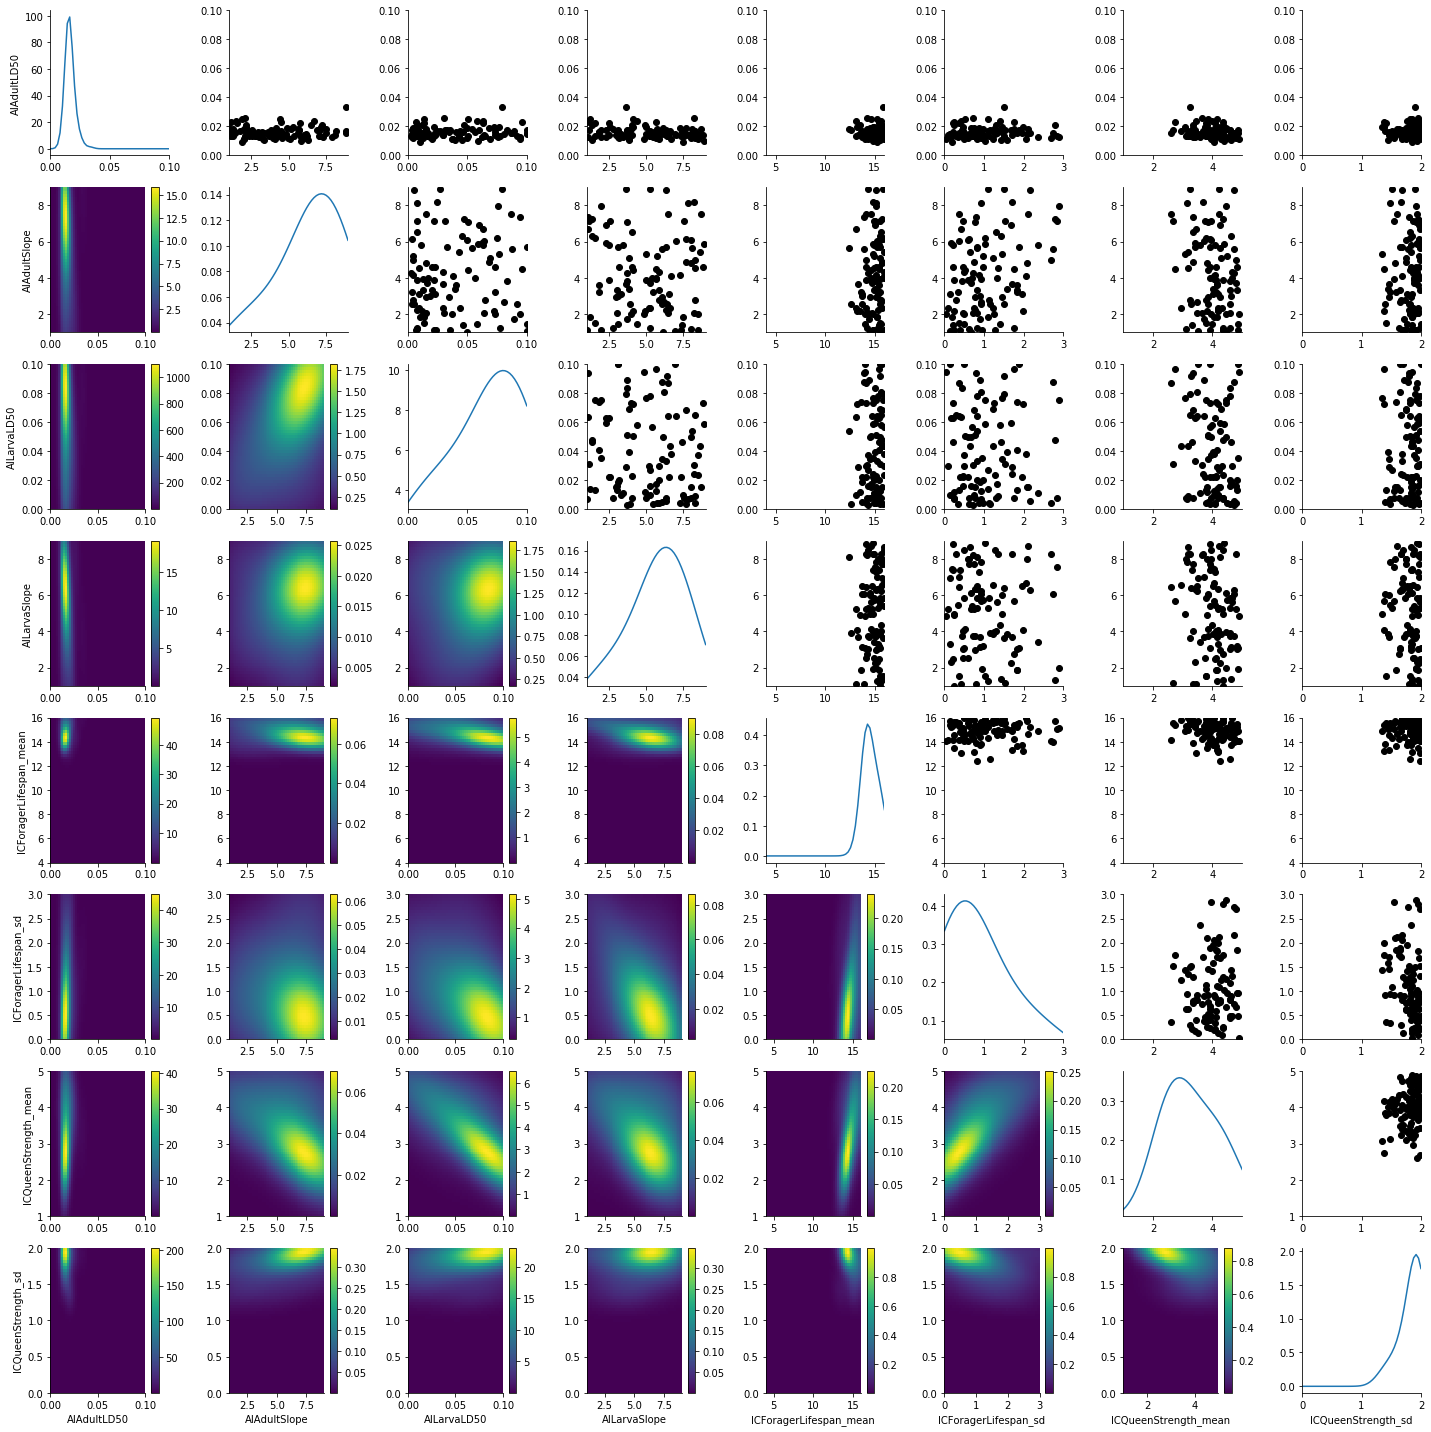

In [13]:
df, w = history.get_distribution(m=0, t=history.max_t)
plot_kde_matrix(df, w, limits=limits);

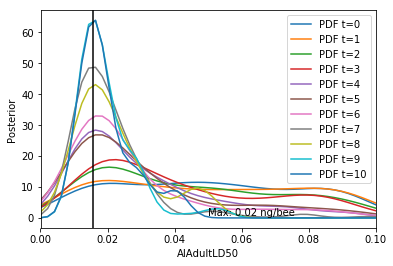

In [22]:
variable = 'AIAdultLD50'
fig, ax = plt.subplots()
for t in range(0,history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0.0001, xmax=0.1,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.legend()
ax.annotate('Max: {:.2f} ng/bee'.format(MAP.item()), xy = (0.05,0.75))
plt.show()

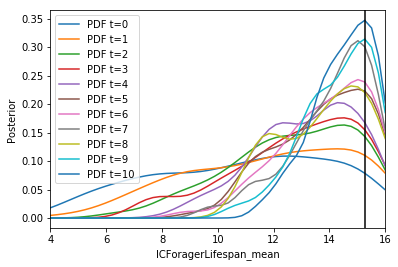

In [24]:
variable = 'ICForagerLifespan_mean'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=4, xmax=16,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
ax.legend()
plt.axvline(x=MAP.item(),color='black')
#ax.annotate('Max: {:.2f} days'.format(MAP.item()), xy = (5.5,0.4))
ax.legend()
plt.show()

### Visualize from a stored run

In [19]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_3_11_2.db"))
history = History(db_path)
history.id = 1

In [20]:
history

In [21]:
df, w = history.get_distribution(m=0, t=history.max_t)

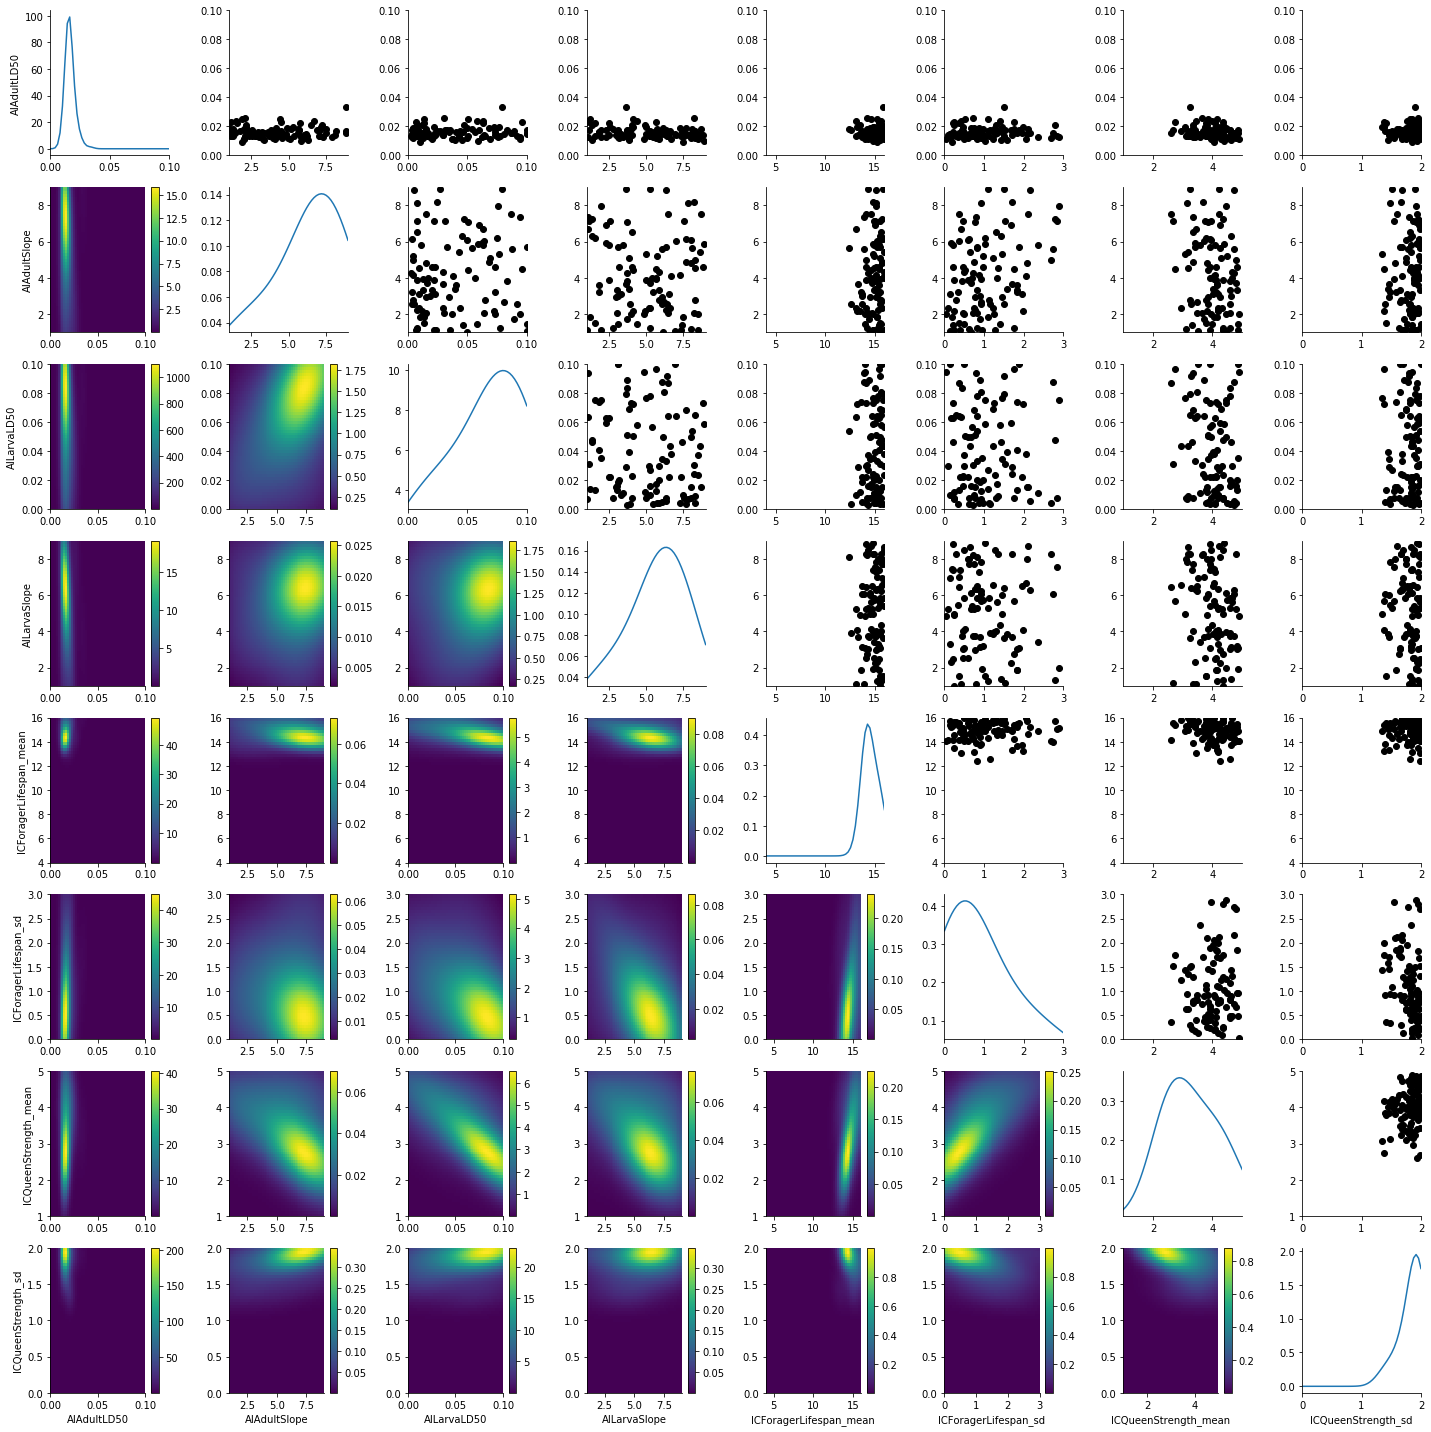

In [8]:
plot_kde_matrix(df, w, limits=limits);

In [9]:
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2019-03-11 16:56:05.391511,0,0.000000,1
1,0,2019-03-12 07:09:25.752604,963,244111.638117,500
2,1,2019-03-13 05:03:42.477176,1161,221549.142742,500
3,2,2019-03-14 06:47:42.578726,1404,210220.408074,500
4,3,2019-03-16 04:11:05.040127,1692,202346.625814,500
5,4,2019-03-19 14:59:39.152900,2649,194696.817142,500
6,5,2019-03-21 02:37:31.727082,3167,189350.870015,500
7,6,2019-03-24 16:08:47.254159,4587,185265.327136,500
8,7,2019-03-26 21:18:09.247548,5545,181547.706854,500
9,8,2019-03-29 13:28:17.235730,6906,178496.458997,500


### Continuing a stopped run

In [6]:
#retrieve stored run 
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_3_11_2.db"))
#db = History(db_path)
#db.id = 3

In [8]:
# define the ABCSMC object
abc_cont = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(100, max_population_size = 100),
             transitions = transition,
             sampler=sampler)

In [ ]:
abc_cont.load(db_path,1)

In [ ]:
abc_cont.run(minimum_epsilon=0, max_nr_populations=100)